## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [1]:
import numpy as np
import math
import pandas as pd
import re
import string
import random
import json

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix


from tqdm import tqdm
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
nltk.download('popular', quiet=True)

stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

C:\Users\Saleh Alkhalifa\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict
C:\Users\Saleh Alkhalifa\anaconda3\lib\site-packages\sklearn\utils\multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
C:\Users\Saleh Alkhalifa\anaconda3\lib\site-packages\sklearn\utils\optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
C:\Users\Saleh Alkhalifa\anaconda3\lib\site-packages\sklearn\utils\optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` f

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
df.head()  # print head of data frame with help of head function

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

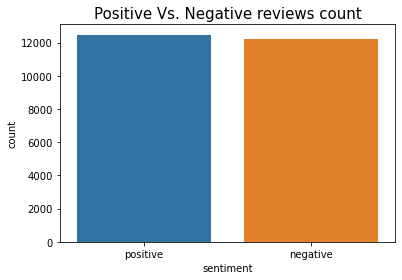

In [4]:
plt.figure(figsize = None)
sns.countplot(df["sentiment"])
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


In [5]:
df["sentiment"].value_counts()

positive    12474
negative    12225
Name: sentiment, dtype: int64

## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [6]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df["sentiment"] == "positive"]
df_minority = df[df["sentiment"] == "negative"]

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [7]:
df_upsampled.shape

(24948, 2)

In [8]:
df_upsampled.head()

,review,sentiment
3011,"I checked this out for free at the library, an...",negative
12551,This movie is a good example of the extreme la...,negative
928,Although the premise of the movie involves a m...,positive
12158,This film is the most impressing turkish film ...,positive
22195,"This comic book style film is funny, has nicel...",positive


In [9]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
negative_upsample.shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [10]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_majority.shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [11]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled["sentiment"] == "negative"].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled["sentiment"] == "positive"].iloc[:10000]


## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled["sentiment"] == "negative"].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled["sentiment"] == "positive"].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train["review"], negative_data_points_train["review"]])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train["sentiment"], negative_data_points_train["sentiment"]])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test["review"], negative_data_points_test["review"]])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test["sentiment"], negative_data_points_test["sentiment"]])


In [12]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
print(y_train.value_counts())

positive    10000
negative    10000
Name: sentiment, dtype: int64


### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [13]:
print(y_test.value_counts())

positive    2474
negative    2474
Name: sentiment, dtype: int64


### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [14]:
sample_review = X_train.sample(1).values[0]
sample_review

'I really truly enjoyed this movie. (Which is why it surprised me that it got such a low rating from so many users at this site!) I am not saying that it is a cinematic masterpiece but it was a great way to spend a cold, snowy Saturday night. It is funny, poignant, and a great tales of the ups and downs of female friendships lasting through difficult times and the bad things that female friends tend to do to each others! (fess up ladies, we have ALL BEEN THERE!) Bill Paterson shines as the Reverand Gerald Marsden and Andie McDowell proves that she can be a fine actress when the role is right and she puts her mind to it. (And truly, there is the best "wedding escape" that I have ever seen or dreamed up in this film ... more guts than anyone I have ever known!) You will laugh and you will cry --- ignore any marketing campaigns and how this film is being marketing .... it is a hidden gem that should have done TONNES of box office. (now I have to look around to purchase a copy!)'

In [15]:
# TASK CELL

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    # Convert lowercase
    review_cleaned = review.lower()
    
    # Remove links
    review_cleaned = re.sub(r"http\S+", "", review_cleaned) # replaces URLs starting with http 
    review_cleaned = re.sub(r"www.\S+", "", review_cleaned) # replaces URLs starting with www
    review_cleaned = re.sub(r"\S+.com$", "", review_cleaned) # replaces URLs ending with .com
    
    # Remove HTML tags
    #     review_cleaned = re.sub(r"<[^>]*>", " ", review_cleaned) # Removes HTML tags such as <br> <br/>
    
    # Remove punctuation
    review_cleaned  = "".join([char for char in review_cleaned if char not in string.punctuation]) #Causes spacing issues like "horrendousbr" from "horrendous.<br />"
    #     review_cleaned = review_cleaned.translate(string.punctuation)
    
    # Remove stopwords
    review_cleaned = " ".join([word for word in re.split('\W+', review_cleaned) if word not in stopword])
    
    # Stem the words
    review_cleaned = " ".join([ps.stem(word) for word in re.split('\W+', review_cleaned)])
    
    # Remove multiple spaces
    #     review_cleaned = re.sub(' +', ' ', review_cleaned)
    
    return review_cleaned

clean_review(sample_review)

'realli truli enjoy movi surpris got low rate mani user site say cinemat masterpiec great way spend cold snowi saturday night funni poignant great tale up down femal friendship last difficult time bad thing femal friend tend other fess ladi bill paterson shine reverand gerald marsden andi mcdowel prove fine actress role right put mind truli best wed escap ever seen dream film gut anyon ever known laugh cri ignor market campaign film market hidden gem done tonn box offic look around purchas copi'

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [16]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    
    # Define a tuple comprising the word and label
    current_pair = (word, label)
    
    # If the word and label tuple exist
    if (current_pair in frequency):
        
        # Set that to variable n
        n = frequency[current_pair]
        
        # Return n
        return n
    
    # If the word and label tuple do not exist
    else:
        return 0

In [17]:
# Testing the function:

frequency = {
    ("nissan", 1) : 1,
    ("nissan", 0) : 4,
    ("ford", 0) : 8,
    ("toyota", 0) : 15,
    ("tesla", 0) : 16,    
    ("audi", 0) : 23,    
    ("bmw", 0) : 42   
}


word = "nissan"
label= 1
    
print(find_occurrence(frequency, "nissan", 1))
print(find_occurrence(frequency, "nissan", 0))
print(find_occurrence(frequency, "tesla", 55))
print(find_occurrence(frequency, "nothing", -55))
print(find_occurrence(frequency, "tesla", 0))


1
4
0
0
16


### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [18]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [19]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [20]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'Although the premise of the movie involves a major "coincidence," the actors all do a creditable job and look great bringing the story to life. I found myself rooting for the characters played by Mary Tyler Moore and Christine Lahti, empathizing with both, and wanting them to reconcile. Sam Waterston and Ted Danson are fine in their roles as well, doing a decent job with the stereotypical buddy relationship. While the story tends to leap through time, occasionally leaving the audience perhaps a little hungry for missing detail, it still flows and avoids any real confusion. This interesting storyline has all the elements for a good "chick flick."'

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [21]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

although premis movi involv major coincid actor credit job look great bring stori life found root charact play mari tyler moor christin lahti empath want reconcil sam waterston ted danson fine role well decent job stereotyp buddi relationship stori tend leap time occasion leav audienc perhap littl hungri miss detail still flow avoid real confus interest storylin element good chick flick


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [22]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in tqdm(zip(positive_or_negative, reviews), total=len(positive_or_negative)):
        split_review = clean_review(review).split()
        for word in split_review:

            # Define the current pair of word and label
            current_pair = (word, label)
            
            # if the key exists in the dictionary, increment the count
            if (current_pair in output_occurrence):
                output_occurrence[current_pair] += 1
                
            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                output_occurrence[current_pair] = 1
   
    return output_occurrence
   


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [23]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result, reviews, ys)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [24]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:54<00:00, 368.94it/s]


In [25]:
len(freqs)

98476

In [26]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
#freqs
random.choice(list(freqs))

('pair', 1)

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [27]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = list(set(item[0] for item in freqs))
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = y_train.shape[0]

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = sum(x > 0 for x in y_train)

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = sum(x < 1 for x in y_train)

    # Calculate logprior
    logprior = math.log(pos_num_docs) - math.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 1)
        freq_neg = find_occurrence(freqs, word, 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = math.log(p_w_pos / p_w_neg)


    return logprior, loglikelihood

In [28]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood)) #Different because of some of the preprocessing methods used

0.0
74950


### Expected Output 

0.0 <br>
91425

In [29]:
# exporting loglikelihood

with open('text_classification_module/artifacts/loglikelihood.json', 'w') as fp:
    json.dump(loglikelihood, fp)

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [30]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
      # process the review to get a list of words
    word_l = clean_review(review).split(" ")

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]

    if total_prob < 0:
        return 0
    else:
        return 1

#     return total_prob

In [31]:
# Experiment with your own review.
my_review = "This is a very bad and terrible movie."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


In [32]:
# Experiment with your own review.
my_review = "This movie is amazing and I liked it alot"
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 0


In [33]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 0


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [34]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    for review in test_x:
        
        # if the prediction is > 0
        prediction = naive_bayes_predict(tweet, logprior, loglikelihood)
        
        if prediction > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = math.mean( mean.abs(y_hats - test_y ))

    # simply subtract 1 in order to calcualte the error
    accuracy = 1 - error


    return accuracy

In [35]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [36]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

### Part 1. 
Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
# ## Considering 10000 positive and 10000 negative data points
# negative_data_points_train = df_upsampled[df_upsampled["sentiment"] == "negative"].iloc[:10000]
# positive_data_points_train = df_upsampled[df_upsampled["sentiment"] == "positive"].iloc[:10000]


# ## Considering the remaining data points for test
# negative_data_points_test = df_upsampled[df_upsampled["sentiment"] == "negative"].iloc[10000:]
# positive_data_points_test = df_upsampled[df_upsampled["sentiment"] == "positive"].iloc[10000:]

X_train, X_test, y_train, y_test = train_test_split(df_upsampled["review"],
                                                    df_upsampled["sentiment"].map(output_map), 
                                                    test_size = 0.25,
                                                    random_state=3)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)


X_train:  (18711,)
X_test:  (6237,)
y_train:  (18711,)
y_test:  (6237,)


### Part 2
Calculate model parameters with training set.

In [39]:
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0007482230053525996
74950


### Part 3
Print confusion matrix for training and test set.

In [40]:
from sklearn.metrics import confusion_matrix

[[8416  936]
 [ 489 8870]]


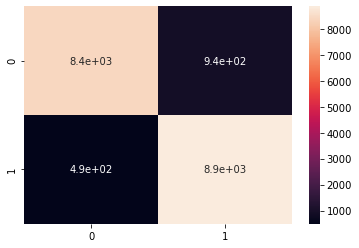

In [41]:
# Training Set

y_pred = []

for review in X_train:
    temp_pred = naive_bayes_predict(review, logprior, loglikelihood)
    y_pred.append(temp_pred)

print(confusion_matrix(y_train, y_pred))
sns.heatmap(confusion_matrix(y_train, y_pred),annot=True);

[[2772  350]
 [ 156 2959]]


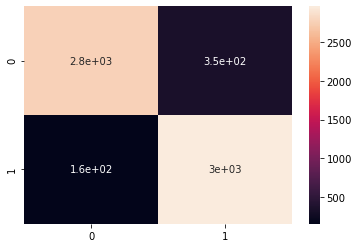

In [42]:
# Testing Set

y_pred = []

for review in X_test:
    temp_pred = naive_bayes_predict(review, logprior, loglikelihood)
    y_pred.append(temp_pred)

print(confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True);

### Part 4
Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

- We can see in the diagram above that our predicted classes are on the y-axis whereas the actual classes are on the x-axis
- One can observe that within the testing data, 2772 datapoints were true positives whereas a smaller faction of 156 were false negatives. 
- On the contrary we can see that 2959 points were true negatives, wherewas 350 were false positives.
- While the true positives and true negatives are significantly larger, we can still see that some false negative and false positives do exist.
- Its important to note that our objective is to maximize the TPs and TNs, and minimize the FPs and FNs.
- It is possible that our preprocessing steps were not sufficient, and additional preprocessing is needed to better generalize over the data
- The data we are working with is real world data, so it possible that some reviews are not long enough, or do not express any type of sentiment
- In addition, we can look over the accuracy, recall, and f1 scores to get another perspective of the model's performance

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.89      0.92      3122
          1       0.89      0.95      0.92      3115

avg / total       0.92      0.92      0.92      6237



# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [44]:
# See separate .py file

# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)

- We use the alpha (a) parameter as it represents a smoothing parameter, also known as additive smoothing
- Smoothing is important for text classification because it helps handle **words that did not appear in the training dataset**
- If a training dataset never had the word 'cat', but it appeared in the testing set, smoothing will help us account for that
- We use this parameter in the form of a **"+1"** in the numerator when calculating the postive and negative probability for a given word
- An alpha value of **0 represents no smoothing**, whereas any value greater than zero does
- We use this parameter to **deal with features that do not appear in training data**; instead of throwing them away, we can smooth instead

For example, my name 'Saleh' never appears in the training dataset, but I can still add that in my review and process it by using the smoothing parameter of '+1'

In [45]:
my_review = 'Saleh is a data scientist'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

In [46]:
my_review = 'The movie about the octopus was great and I really enjoyed it'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

We use smoothing parameters of 1, since the probabily will increase slightly, enough to no longer be zero. We can see this in the example below where a value of 0 and 1 are 'close enough', wheras the values of 10 and 100 are too high.

In [62]:
def p_w_positive(a):
    numerator = 0 + a # In the chance that a value of 0 is added
    denominator = 10 + (2*a) # Sample example
    return numerator/denominator

In [63]:
p_w_positive(0.0)

0.0

In [64]:
p_w_positive(1.0)

0.08333333333333333

In [65]:
p_w_positive(10.0)

0.3333333333333333

In [66]:
p_w_positive(100.0)

0.47619047619047616

2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

- We can use logarithmic values to help calculate joint probabilities for a set of points
- Often times calculating probabilities can lead to an underflow, and therefore logs can help avoid that
- Underflows can occur when the calculations are very small, and we run out of the floating point precision
- This practice can also help from a computational point of view